Задача 1: Прогнозування попиту
Мета: Розробити систему прогнозування попиту на короткостроковий період (14 днів) через 7 днів від останньої дати в даних, для всіх груп товарів.

Модель машинного навчання.

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [46]:
orders = pd.read_csv('orders.csv')
order_items = pd.read_csv('order_items.csv')
products = pd.read_csv('products.csv')

# об'єднання ордерітем і продуктс
data = orders.merge(order_items, on='order_id')
data = data.merge(products, on='product_id')

data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp']) # в datetime

# агрегація даних за днями та категоріями продуктів
daily_sales = data.groupby(['order_purchase_timestamp', 'product_category_name'])['order_item_id'].count().reset_index()
daily_sales = daily_sales.rename(columns={'order_item_id': 'sales'})

# сортування за датою
daily_sales = daily_sales.sort_values('order_purchase_timestamp')

In [47]:
# підготовка даних
def prepare_features(df):
    df['dayofweek'] = df['order_purchase_timestamp'].dt.dayofweek
    df['month'] = df['order_purchase_timestamp'].dt.month
    df['year'] = df['order_purchase_timestamp'].dt.year
    
    for lag in [1, 7, 14]:
        df[f'sales_lag_{lag}'] = df.groupby('product_category_name')['sales'].shift(lag)
    
    le = LabelEncoder()
    df['product_category_name'] = le.fit_transform(df['product_category_name'])
    
    return df

data_prepared = prepare_features(daily_sales)
data_prepared = data_prepared.dropna() 

In [48]:
X = data_prepared.drop(['order_purchase_timestamp', 'sales'], axis=1)
y = data_prepared['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [50]:
# прогнозування
y_pred_xgb = model_xgb.predict(X_test)

# оцінка моделі
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f'MAPE для XGBoost: {mape_xgb}')
print(f'RMSE для XGBoost: {rmse_xgb}')

MAPE для XGBoost: 0.16446525901250783
RMSE для XGBoost: 0.4833918649919987


Класична модель прогнозування часових рядів.

In [9]:
# вибір однієї категорії продуктів для прикладу
category = daily_sales['product_category_name'].unique()[0]
category_sales = daily_sales[daily_sales['product_category_name'] == category].set_index('order_purchase_timestamp')['sales']

train_size = int(len(category_sales) * 0.8)
train, test = category_sales[:train_size], category_sales[train_size:]

model_sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
results_sarima = model_sarima.fit()

forecast = results_sarima.get_forecast(steps=len(test))
y_pred_sarima = forecast.predicted_mean

mape_sarima = mean_absolute_percentage_error(test, y_pred_sarima)
print(f'MAPE для SARIMA: {mape_sarima}')

C:\Users\annbu\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\annbu\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAPE для SARIMA: 0.32042578130896554


C:\Users\annbu\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\annbu\new_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


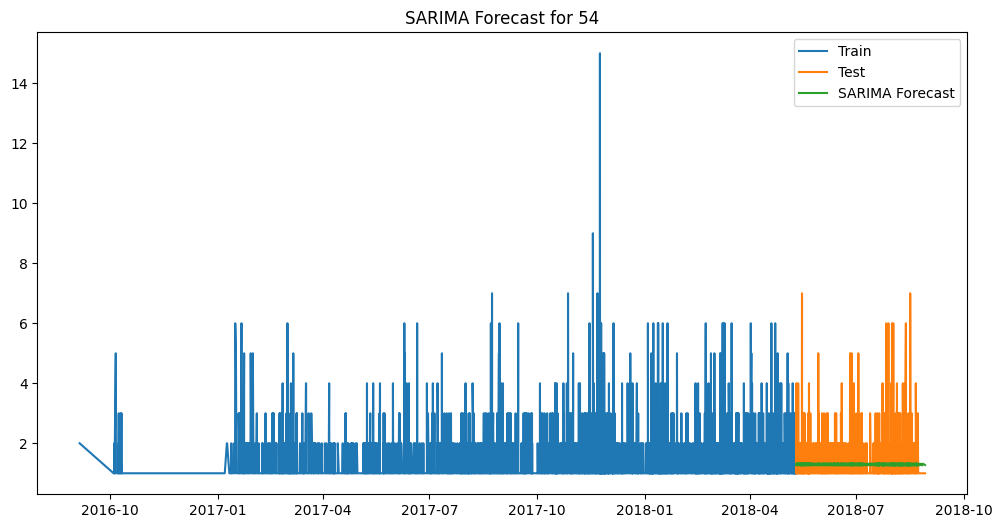

In [12]:
# Візуалізація результатів
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, y_pred_sarima, label='SARIMA Forecast')
plt.legend()
plt.title(f'SARIMA Forecast for {category}')
plt.show()

Обрати дані методи мене спонукало те, що 

XGBoost - це потужний алгоритм машинного навчання, який використовує градієнтний бустинг та ансамблеві методи, що дозволяє досягти високої точності при прогнозуванні також є досить гнучким та швидким, і показало краще результати ніж інші моделі. ХОЧА якщо бути відвертою, результати взагалі не найкращі, але це найкраще, що я змогла зробити через певні обмеження в ресурсі через відключення світла та певні проблеми з моїм середовищем виконання (які я буду надалі виправляти) 

SARIMA добре підходить для моделювання часових рядів, особливо коли є сезонність, що важливо для продажів. У даних спостерігається певна періодичність, тому сезонна компонента моделі є корисною, також вона враховує автокореляцію (AR), інтеграцію (I) та ковзне середнє (MA), що дозволяє врахувати взаємозв'язки в серії даних. Також аналогічна ситуація тут. Також для себе винесла, що потрібно довчити роботу з часовими рядами і обов'язково це зроблю.